1.训练faster-RCNN的代码时，想要一个validation loss，于是将dataset的training改为True，
将模型中if self.training的地方改为if True，于是出现了结果接近于0的问题。
原因：训练集数据与测试集数据预处理方式不同，训练集先裁剪、后填黑边。
解决：训练与测试数据处理不一样，将dataset的training改为False，将模型中if self.training的地方改为if True，然后在roibatchloader.py中加入validation的标签即可。

2.yolov1代码：RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [2, 2]], which is output 0 of SliceBackward, is at version 297; expected version 296 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).
  原因：需要计算梯度的tensor（非叶子节点）在计算loss前被inplace操作修改<br>
（1）loss中：a += b 改为： a = a + b<br/>
（2）model中：inplace操作改为False<br/>
（3）（最终的解决方式）对于loss输入的变量（他们是inplace的），对其修改前要先克隆一份，再在克隆的数据上操作；或者定义一个新变量，利用输入对其赋值操作
   如：将<br/>
    box1 = box_pred[i:i+2]<br/>
    box1[:,:2] = box1[:,:2] * 448 / 14<br/>
    box1[:,2:4] = box1[:,2:4].pow(2) * 448<br/>
    改为：<br/>
    box10 = box_pred[i:i+2]<br/>
    box1 = box10.clone()<br/>
    box1[:,:2] = box1[:,:2] * 448 / 14<br/>
    box1[:,2:4] = box1[:,2:4].pow(2) * 448<br/>

   注：如果需要计算梯度的叶子节点在计算loss前被inplace操作修改，将会报：<br/>
         RuntimeError: leaf variable has been moved into the graph interior<br/>
   （详见：https://blog.csdn.net/byron123456sfsfsfa/article/details/92210253）<br/>

3.yolov1代码：map为0<br/>
原因：loss或gt encode方式有问题，网络收敛的慢<br/>
解决：多训练几次（缓和之计，尚待进一步解决）

4,测试代码多进程报错<br/>
def preds_comp(image_path):<br/>
  result = predict_gpu(model,image_path,root_path='/data/xiaojun/data/voc/VOCdevkit/VOC2007/JPEGImages/')<br/>
        print("result:", result)<br/>
        for (x1,y1),(x2,y2),class_name,image_id,prob in result: #image_id is actually image_path<br/>
            preds[class_name].append([image_id,prob,x1,y1,x2,y2])<br/>

preds = defaultdict(list)<br/>
解决：尚待解决

5.AssertionError: Gather function not implemented for CPU tensors<br/>
原因：model.forward(0函数返回的是一个元祖，里面有3个tensor，其中两个是由input计算而来的，为cuda类型，另一个是加进来的，为cpu类型<br/>
解决：将cpu类型的tensor载入到gpu

6.(ssd)RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method.<br/>
原因：在用torch.autograd.Fuction类自定义算子时，新版的torch要求forward为静态函数<br/>
解决：将detect算子改为新版本的形式（注意，ssd中训练时不需要detect算子，故未实现backward函数）

7.编译错误：nvcc fatal : Path to libdevice library not specified<br/>
解决：修改环境变量文件~/.bashrc:<br/>
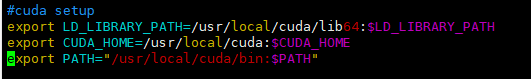
然后运行source ~/.bashrc使得设置生效